In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Loading and Dealing with Data

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Extract the label column and convert it to NumPy
labels = data.pop('label').to_numpy()

In [5]:
labels

array([1, 0, 1, ..., 7, 6, 9], dtype=int64)

In [6]:
# Convert the image to 28 by 28
data = data.to_numpy().reshape(-1,28,28)

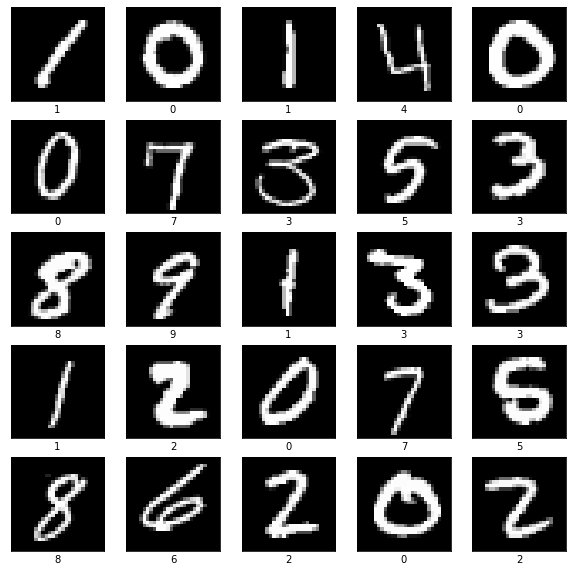

In [7]:
# Display part of picture
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(data[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(labels[i])

In [8]:
# Add a dimension for features and tags
data = np.expand_dims(data,axis=-1)
labels = np.expand_dims(labels,axis=-1)

In [9]:
data.shape

(42000, 28, 28, 1)

In [10]:
labels.shape

(42000, 1)

In [11]:
# Convert the image from 28*28 to 32*32 by adding two rows or columns of 0 around the image
data = tf.pad(data,[[0,0],[2,2],[2,2],[0,0]]).numpy()

In [12]:
data.shape

(42000, 32, 32, 1)

# Data Exploration

In [13]:
# Gets the number of individual tags
s = pd.Series(np.squeeze(labels))
s = s.value_counts().sort_index()

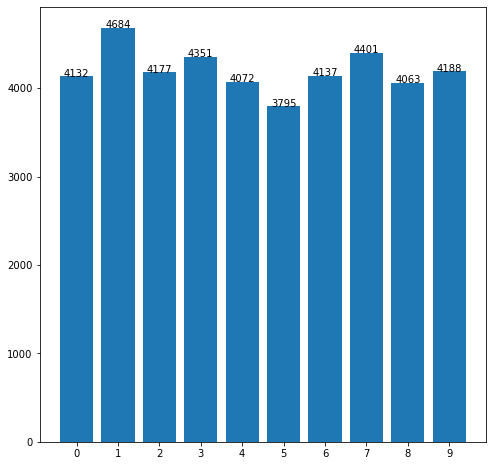

In [14]:
# View the label distribution
plt.figure(figsize=(8,8))
rects = plt.bar(s.index,s.values)
plt.xticks(s.index)

for rect in rects:
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()/2,height,str(height),ha='center')
plt.show()

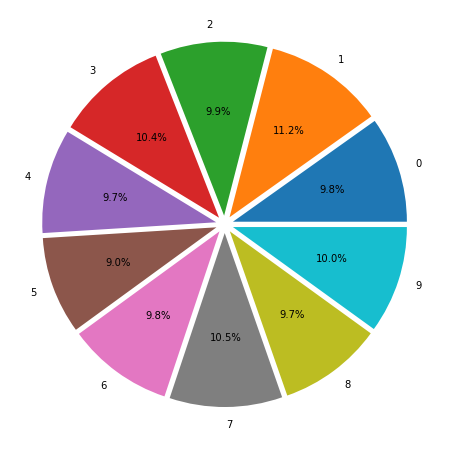

In [15]:
# Look at the scale of each TAB
plt.figure(figsize=(8,8))

plt.pie(s.values,explode=[0.05 for i in range(10)], labels=s.index,autopct='%1.1f%%')
plt.show()

# DataSet Split

In [16]:
# Using stratified sampling, the data set was divided into training set, 
# verification set and test set according to 8:1:1, Each of these data sets has the same proportion of categories

train_other_sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

for train_index, other_index in train_other_sss.split(data, labels):
    train_data, train_label = data[train_index], labels[train_index]
    other_data, other_label = data[other_index], labels[other_index]

val_test_sss = StratifiedShuffleSplit(n_splits=1,test_size=0.5,random_state=42)

for val_index, test_index in val_test_sss.split(other_data, other_label):
    val_data, val_label = other_data[val_index], other_label[val_index]
    test_data, test_label = other_data[test_index], other_label[test_index]

In [17]:
print('train:',train_data.shape,'-- label:',train_label.shape)
print('validition:',val_data.shape,'-- label:',val_label.shape)
print('test:',test_data.shape,'-- label:',test_label.shape)

train: (33600, 32, 32, 1) -- label: (33600, 1)
validition: (4200, 32, 32, 1) -- label: (4200, 1)
test: (4200, 32, 32, 1) -- label: (4200, 1)


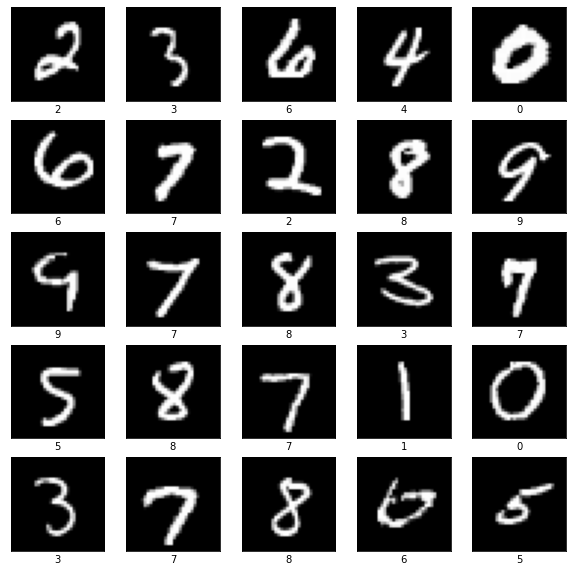

In [18]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_data[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(train_label[i][0])

* View the distribution of the partitioned dataset

In [19]:
# Gets the percentage of each label in each dataset
labels = [train_label,val_label,test_label]
keys = ['train','val','test']
value = {}
for i,label in enumerate(labels):
    s = pd.Series(np.squeeze(label)).value_counts().sort_index()
    s = s / s.sum()
    value[keys[i]] = s.values

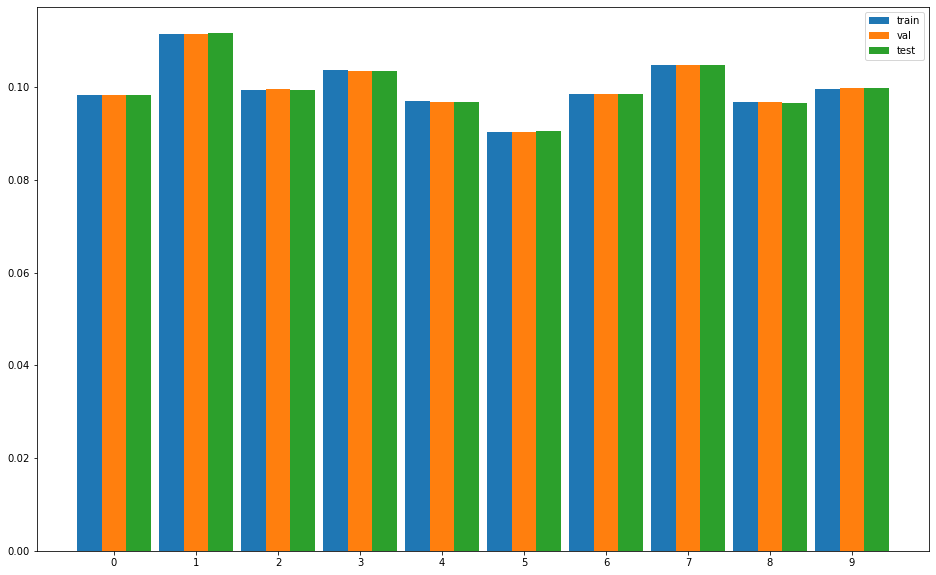

In [20]:
# It can be seen that after stratified sampling, each label of training set, 
# verification set and test set accounts for the same proportion

plt.figure(figsize=(16,10))
x = np.arange(10)
width = 0.3
plt.bar(x, value['train'], label='train',width=0.3)
plt.bar(x+width, value['val'], label='val',width=0.3)
plt.bar(x+2*width, value['test'], label='test',width=0.3)
plt.xticks(x+width,[i for i in range(10)])
plt.legend()
plt.show()

# Build Model

In [21]:
image_shape = (32,32,1)

In [22]:
# Use Monte Carlo Dropout to reduce overfitting

class MCDropout(layers.Dropout):
    def call(self,inputs):
        return super().call(inputs,training=True)

inputs = layers.Input(shape=image_shape)
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs) # normalized
x = layers.Conv2D(128,5,strides=1,activation='relu')(x)
x = layers.MaxPooling2D(2,strides=2)(x)
x = layers.Conv2D(128,5,strides=1,activation='relu')(x)
x = layers.MaxPooling2D(2,strides=2)(x)
x = layers.Conv2D(128,5,strides=1,activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(84,activation='relu')(x)
x = MCDropout(0.1)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs,outputs)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [23]:
# 查看网络结构
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       409728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 128)         409728

In [24]:
# Early termination is used. When the accuracy of verification set is not improved for 10 times, 
# the training is ended
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',
                                    patience=10,restore_best_weights=True)

# Learning rate scheduling is used. When the accuracy of verification set does not improve for 5 times, 
# the learning rate is halved
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                    mode='max',factor=0.5,patience=5)

history = model.fit(train_data,train_label,batch_size=128,epochs=100,
                    validation_data=(val_data,val_label),
                    callbacks=[early_stopping,lr_scheduler])

Epoch 1/100
263/263 [==============================] - 13s 29ms/step - loss: 0.5907 - accuracy: 0.8078 - val_loss: 0.0902 - val_accuracy: 0.9752
Epoch 2/100
263/263 [==============================] - 5s 21ms/step - loss: 0.0688 - accuracy: 0.9790 - val_loss: 0.0565 - val_accuracy: 0.9838
Epoch 3/100
263/263 [==============================] - 5s 21ms/step - loss: 0.0391 - accuracy: 0.9880 - val_loss: 0.0622 - val_accuracy: 0.9821
Epoch 4/100
263/263 [==============================] - 5s 21ms/step - loss: 0.0273 - accuracy: 0.9905 - val_loss: 0.0447 - val_accuracy: 0.9874
Epoch 5/100
263/263 [==============================] - 5s 20ms/step - loss: 0.0196 - accuracy: 0.9939 - val_loss: 0.0510 - val_accuracy: 0.9855
Epoch 6/100
263/263 [==============================] - 5s 21ms/step - loss: 0.0164 - accuracy: 0.9947 - val_loss: 0.0395 - val_accuracy: 0.9890
Epoch 7/100
263/263 [==============================] - 5s 21ms/step - loss: 0.0120 - accuracy: 0.9965 - val_loss: 0.0505 - val_accuracy

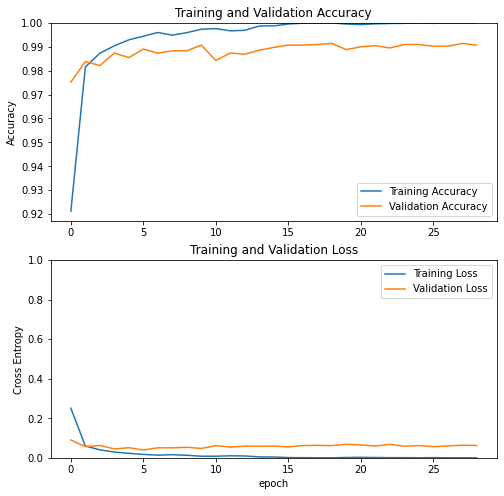

In [25]:
# Painting learning curve

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
# test
model.evaluate(test_data,test_label,verbose=2)

132/132 - 1s - loss: 0.0380 - accuracy: 0.9912


[0.03797727823257446, 0.991190493106842]

# Model evaluation

In [38]:
# Evaluate on the test set
test_predict = model.predict(test_data)
test_predict = np.argmax(test_predict, axis=-1)
test_label = np.squeeze(test_label)

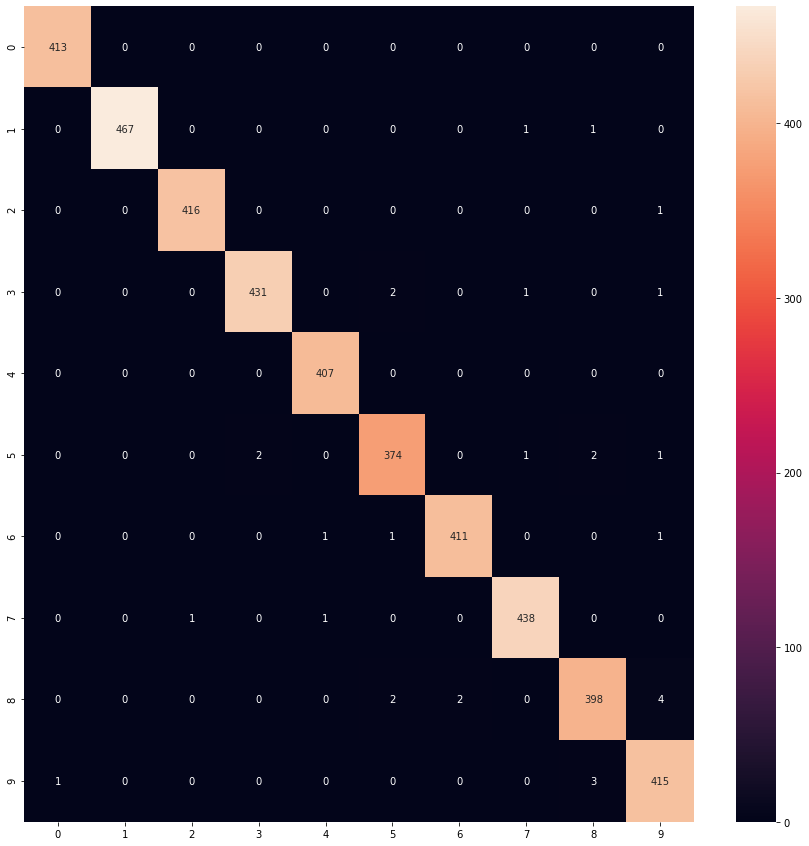

In [53]:
# Drawing the confusion matrix, we can see that 0 and 4 are all correctly classified, while 5 and 8 are more wrong

cm = confusion_matrix(test_label, test_predict)
plt.figure(figsize=(15,15))
sns.heatmap(cm,annot=True,fmt='')
plt.show()

In [67]:
# Obtain misclassified images and misclassified labels
# count the number of misclassified categories

index = list(range(10))
errors = {str(i):([],[]) for i in range(10)}
errors_num = [0 for _ in range(10)]
for i,image in enumerate(test_data):
    if test_label[i] != test_predict[i]:
        errors[str(test_label[i])][0].append(image)
        errors[str(test_label[i])][1].append(test_predict[i])
        errors_num[test_label[i]] += 1

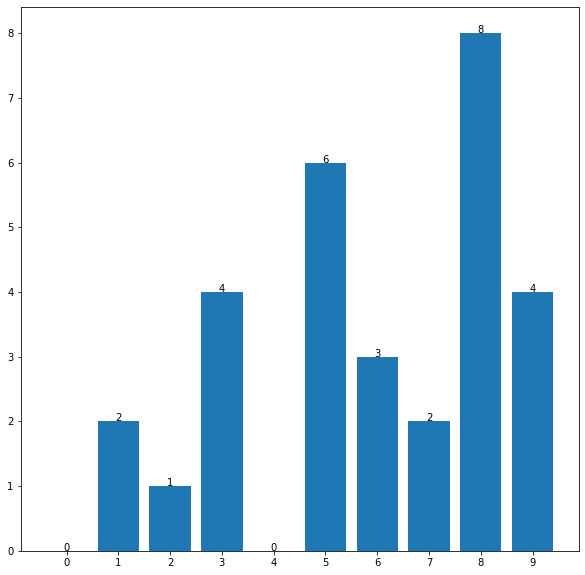

In [64]:
# Draw a bar chart showing the number of predicted errors for each label

plt.figure(figsize=(10,10))
rects = plt.bar(index,errors_num)

for rect in rects:
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()/2,height,str(height),ha='center')

plt.xticks(index)
plt.show()

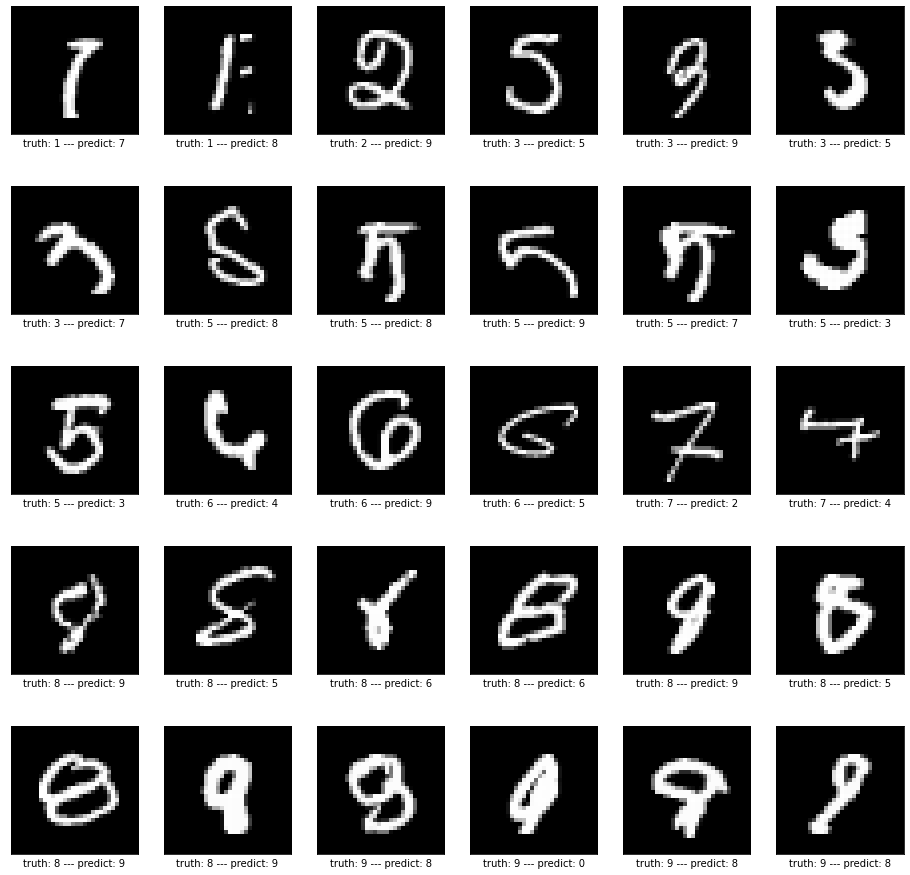

In [71]:
# Show the picture of the wrong prediction

plt.figure(figsize=(16,16))
key = errors.keys()
n = 1
for k in key:
    for i in range(len(errors[k][0])):
        plt.subplot(5,6,n)
        plt.imshow(errors[k][0][i],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('truth: {} --- predict: {}'.format(k,errors[k][1][i]))
        n += 1
plt.show()

# As you can see, some of these mispredicted images are hard to read

# prediction

In [79]:
# Load the prediction image and do the same to it as before

test = pd.read_csv('test.csv')
test = test.values
test = test.reshape(-1,28,28)
test = np.expand_dims(test,-1)
test = tf.pad(test,[[0,0],[2,2],[2,2],[0,0]]).numpy()

In [80]:
test.shape

(28000, 32, 32, 1)

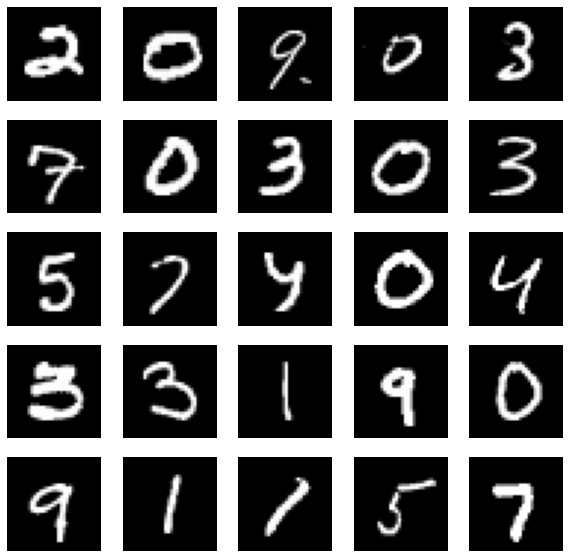

In [82]:
# Show part of the forecast picture

plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(test[i],cmap='gray')
    plt.axis('off')
plt.show()

In [83]:
# Predict
predict = model.predict(test)
predict = np.argmax(predict,axis=-1)

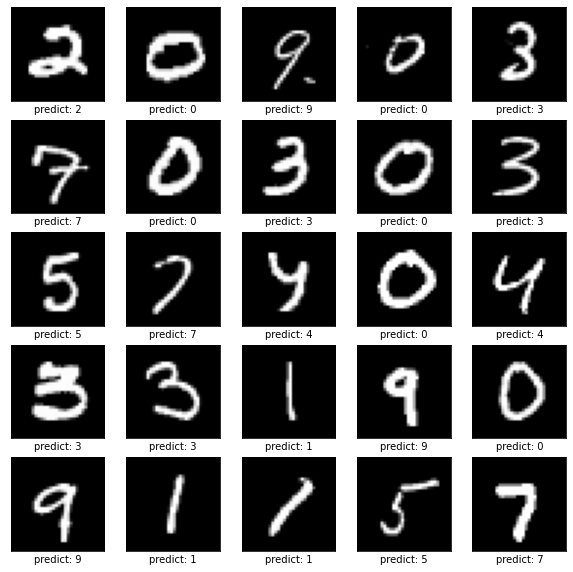

In [84]:
# Display forecast results
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(test[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('predict: {}'.format(predict[i]))
plt.show()